In [1]:
#构建模型

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer #我们使用TF-IDF

df = pd.read_csv("E:/作业/杂物/web日志分析/final_dataset_400k.csv")

y = df["label"]

path = df["path"].fillna("")
status = df["status"].fillna(0)
method = df["method"].fillna("")
size = df["size"].fillna(0)
referer = df["referer"].fillna("")
user_agent = df["user_agent"].fillna("")

vec_path = TfidfVectorizer(max_features=5000)
vec_ua = TfidfVectorizer(max_features=5000)
vec_referer = TfidfVectorizer(max_features=5000)

x_path = vec_path.fit_transform(path)
x_ua = vec_ua.fit_transform(user_agent)
x_referer =vec_referer.fit_transform(referer)

ohe = OneHotEncoder(handle_unknown='ignore')  # One-Hot 编码
x_method = ohe.fit_transform(method.values.reshape(-1, 1))

x_status= status.values.reshape(-1, 1)   # 数值特征转成二维
x_size= size.values.reshape(-1, 1)


x = hstack([x_path, x_ua, x_referer, x_method, x_status, x_size])  # 合并所有特征必须使用稀疏矩阵拼接

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# 模型1：朴素贝叶斯
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("朴素贝叶斯模型评估：")
print(classification_report(y_test, y_pred_nb))

# 模型2：逻辑回归
lr = LogisticRegression(max_iter=2000, solver='saga')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("逻辑回归：")
print(classification_report(y_test, y_pred_lr))

In [2]:
# 模型3:XGBoost

import xgboost as xgb
import numpy as np
params={
    'objective':'binary:logistic', #目标函数，我们明显是二分类用 binary:logistic
    'eval_metric':'logloss', #评估指标，这里用 logloss
    'eta': 0.05, #学习率，值越小越稳越慢默认0.1
    'max_depth': 8, #每棵树的深度，越深越复杂一般4-6复杂可到8
    'subsample': 1.0, #样本采样比例，防止过拟合
    'colsample_bytree': 0.8, #特征采样比例
}  #不是特别理解好像就是不同的参数,感觉很难记住

y_np = np.array(y_train)
dtrain = xgb.DMatrix(X_train, label=y_np) 
bst = xgb.train(params, dtrain, num_boost_round=100)
dtest = xgb.DMatrix(X_test)
y_pred_prob = bst.predict(dtest)   # 输出是概率
y_pred = (y_pred_prob > 0.5).astype(int)
print("XGBoost：")
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


XGBoost：
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     40134
           1       1.00      0.99      0.99     39866

    accuracy                           0.99     80000
   macro avg       0.99      0.99      0.99     80000
weighted avg       0.99      0.99      0.99     80000



开始计算学习曲线...
训练集大小: ['32000', '64000', '96000', '128000', '160000', '192000', '224000', '256000', '288000', '320000']
正在计算训练集大小为 10.0% 的结果...
  第 1 折...
  第 2 折...
  第 3 折...
正在计算训练集大小为 20.0% 的结果...
  第 1 折...
  第 2 折...
  第 3 折...
正在计算训练集大小为 30.0% 的结果...
  第 1 折...
  第 2 折...
  第 3 折...
正在计算训练集大小为 40.0% 的结果...
  第 1 折...
  第 2 折...
  第 3 折...
正在计算训练集大小为 50.0% 的结果...
  第 1 折...
  第 2 折...
  第 3 折...
正在计算训练集大小为 60.0% 的结果...
  第 1 折...
  第 2 折...
  第 3 折...
正在计算训练集大小为 70.0% 的结果...
  第 1 折...
  第 2 折...
  第 3 折...
正在计算训练集大小为 80.0% 的结果...
  第 1 折...
  第 2 折...
  第 3 折...
正在计算训练集大小为 90.0% 的结果...
  第 1 折...
  第 2 折...
  第 3 折...
正在计算训练集大小为 100.0% 的结果...
  第 1 折...
  第 2 折...
  第 3 折...


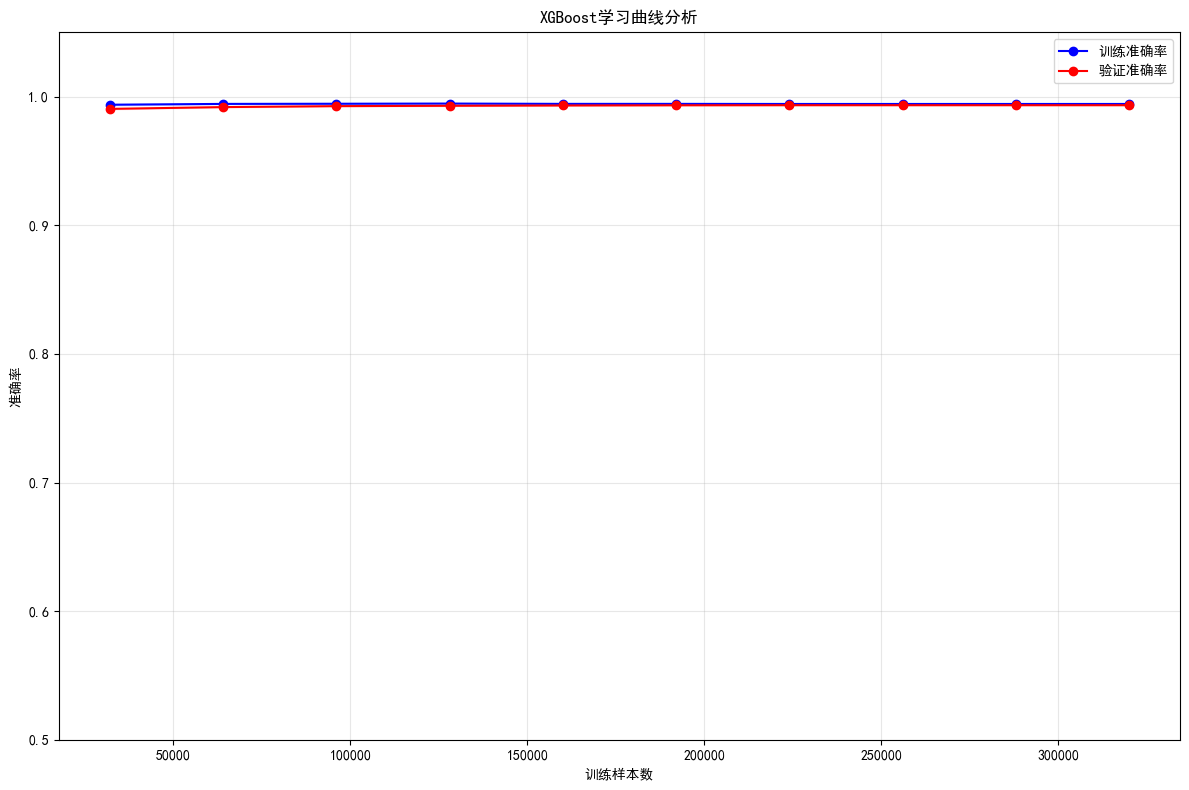


=== 学习曲线分析结果 ===
训练样本数      训练准确率           验证准确率           差异      
-------------------------------------------------------
32000      0.9937±0.0005  0.9904±0.0003  0.0032
64000      0.9943±0.0002  0.9918±0.0002  0.0025
96000      0.9944±0.0003  0.9926±0.0002  0.0019
128000     0.9946±0.0001  0.9928±0.0002  0.0017
160000     0.9943±0.0002  0.9931±0.0001  0.0013
192000     0.9943±0.0000  0.9932±0.0001  0.0011
224000     0.9943±0.0003  0.9933±0.0002  0.0010
256000     0.9943±0.0003  0.9933±0.0002  0.0010
288000     0.9943±0.0003  0.9933±0.0002  0.0010
320000     0.9943±0.0003  0.9933±0.0002  0.0010

=== 分析结论 ===
最终训练准确率: 0.9943
最终验证准确率: 0.9933
过拟合程度: 0.0010
✓ 模型拟合良好，过拟合程度较低
✓ 验证准确率很高，模型性能优秀


In [15]:
# 学习曲线分析 - 基于你的代码结构
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import xgboost as xgb

# 使用你的参数
params={
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 1.0,
    'colsample_bytree': 0.8,
}

# 设置不同的训练集大小
train_sizes = np.linspace(0.1, 1.0, 10)
train_scores = []
val_scores = []

print("开始计算学习曲线...")
print("训练集大小:", [f"{int(size*X_train.shape[0])}" for size in train_sizes])

# 3折交叉验证
kf = KFold(n_splits=3, shuffle=True, random_state=42)

for train_size in train_sizes:
    print(f"正在计算训练集大小为 {train_size:.1%} 的结果...")
    
    # 当前训练集大小对应的样本数
    n_samples = int(train_size * X_train.shape[0])
    
    train_scores_fold = []
    val_scores_fold = []
    
    # 交叉验证
    fold_count = 0
    for train_idx, val_idx in kf.split(X_train):
        fold_count += 1
        print(f"  第 {fold_count} 折...")
        
        # 获取当前fold的训练和验证数据
        X_fold_train = X_train[train_idx]
        y_fold_train = np.array(y_train)[train_idx]
        X_fold_val = X_train[val_idx]
        y_fold_val = np.array(y_train)[val_idx]
        
        # 只使用部分训练数据
        X_fold_train_subset = X_fold_train[:n_samples]
        y_fold_train_subset = y_fold_train[:n_samples]
        
        # 构建DMatrix
        dtrain_fold = xgb.DMatrix(X_fold_train_subset, label=y_fold_train_subset)
        dval_fold = xgb.DMatrix(X_fold_val, label=y_fold_val)
        
        # 训练模型
        bst_fold = xgb.train(params, dtrain_fold, num_boost_round=100, verbose_eval=False)
        
        # 预测训练集
        train_pred_prob = bst_fold.predict(dtrain_fold)
        train_pred = (train_pred_prob > 0.5).astype(int)
        train_acc = np.mean(train_pred == y_fold_train_subset)
        train_scores_fold.append(train_acc)
        
        # 预测验证集
        val_pred_prob = bst_fold.predict(dval_fold)
        val_pred = (val_pred_prob > 0.5).astype(int)
        val_acc = np.mean(val_pred == y_fold_val)
        val_scores_fold.append(val_acc)
    
    # 计算当前训练集大小的平均分数
    train_scores.append(train_scores_fold)
    val_scores.append(val_scores_fold)

# 转换为numpy数组
train_scores = np.array(train_scores)
val_scores = np.array(val_scores)

# 计算均值和标准差
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# 绘制学习曲线
plt.figure(figsize=(12, 8))
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

train_sizes_actual = [int(size * X_train.shape[0]) for size in train_sizes]

plt.plot(train_sizes_actual, train_mean, 'o-', color='blue', label='训练准确率')
plt.fill_between(train_sizes_actual, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes_actual, val_mean, 'o-', color='red', label='验证准确率')
plt.fill_between(train_sizes_actual, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.xlabel('训练样本数')
plt.ylabel('准确率')
plt.title('XGBoost学习曲线分析')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0.5, 1.05)

plt.tight_layout()
plt.show()

# 打印详细结果
print("\n=== 学习曲线分析结果 ===")
print(f"{'训练样本数':<10} {'训练准确率':<15} {'验证准确率':<15} {'差异':<8}")
print("-" * 55)
for i, size in enumerate(train_sizes_actual):
    diff = train_mean[i] - val_mean[i]
    print(f"{size:<10} {train_mean[i]:.4f}±{train_std[i]:.4f}  {val_mean[i]:.4f}±{val_std[i]:.4f}  {diff:.4f}")

# 分析结果
final_train_acc = train_mean[-1]
final_val_acc = val_mean[-1]
overfitting_gap = final_train_acc - final_val_acc

print(f"\n=== 分析结论 ===")
print(f"最终训练准确率: {final_train_acc:.4f}")
print(f"最终验证准确率: {final_val_acc:.4f}")
print(f"过拟合程度: {overfitting_gap:.4f}")

if overfitting_gap < 0.02:
    print("✓ 模型拟合良好，过拟合程度较低")
elif overfitting_gap < 0.05:
    print("⚠ 存在轻微过拟合")
else:
    print("❌ 存在明显过拟合，建议调整参数")

if final_val_acc > 0.95:
    print("✓ 验证准确率很高，模型性能优秀")
elif final_val_acc > 0.85:
    print("✓ 验证准确率良好")
else:
    print("⚠ 验证准确率偏低，可能需要改进特征或调参")